In [1]:
!pip install pyspark

## 1. Create session and read data

In [24]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

First we need to create a Spark session. Spark session acts as an entry point for any Spark applications

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.\
        builder.\
        appName("SparkApp_Delhi").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()
spark

In [5]:
dataset_path = "hdfs://hadoop:9000/test/Delhi-house-data.csv"
df = spark.read.option("multiline", "true").csv("hdfs://hadoop:9000/test/Delhi-house-data.csv", header=True, inferSchema=True)
df.show(10)

+------+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+--------+
|  Area|BHK|Bathroom|    Furnishing|            Locality|Parking|   Price|       Status| Transaction|         Type|Per_Sqft|
+------+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+--------+
| 800.0|  3|       2|Semi-Furnished|    Rohini Sector 25|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|    null|
| 750.0|  2|       2|Semi-Furnished|J R Designers Flo...|      1| 5000000|Ready_to_move|New_Property|    Apartment|    6667|
| 950.0|  2|       2|     Furnished|Citizen Apartment...|      1|15500000|Ready_to_move|      Resale|    Apartment|    6667|
| 600.0|  2|       2|Semi-Furnished|    Rohini Sector 24|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|    6667|
| 650.0|  2|       2|Semi-Furnished|Rohini Sector 24 ...|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|    6667|


In [6]:
print('Number of rows: ', df.count())
print('Columns: ', df.columns)
print('Number of columns: ', len(df.columns))

Number of rows:  1259
Columns:  ['Area', 'BHK', 'Bathroom', 'Furnishing', 'Locality', 'Parking', 'Price', 'Status', 'Transaction', 'Type', 'Per_Sqft']
Number of columns:  11


In [7]:
df.printSchema()

root
 |-- Area: double (nullable = true)
 |-- BHK: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Furnishing: string (nullable = true)
 |-- Locality: string (nullable = true)
 |-- Parking: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Transaction: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Per_Sqft: integer (nullable = true)



## 2.Data cleaning

In [8]:
from pyspark.sql.functions import col,isnan,when,count,udf,mean
from pyspark.sql.types import StringType, IntegerType, FloatType

### 2.1. Process NULL values

First we count the number of NULL values in the dataset

In [9]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+--------+----------+--------+-------+-----+------+-----------+----+--------+
|Area|BHK|Bathroom|Furnishing|Locality|Parking|Price|Status|Transaction|Type|Per_Sqft|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+--------+
|   0|  0|       2|         5|       0|     33|    0|     0|          0|   5|     241|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+--------+



As there are too many NULL values in the Per_sqft column (241 rows compared to 1259 total sample size), also the meaning of this column is unclear, we will remove this column

In [10]:
df = df.drop('Per_sqft')

The number rows with NULL values for columns Bathroom, Furnishing and Type is insignificant, we can remove them.

In [11]:
df = df.dropna('any', subset=['Bathroom', 'Furnishing', 'Type'])

The column Parking has 33 NULL values, removing all the NULL rows can lead to considerable data loss, a better solution is to replace the NULL cells with the median value of all other Parking values

In [12]:
median_parking = round(df.approxQuantile("Parking", [0.5], 0)[0])
df = df.fillna(median_parking, 'Parking')
print(median_parking)

1


In [13]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+--------+----------+--------+-------+-----+------+-----------+----+
|Area|BHK|Bathroom|Furnishing|Locality|Parking|Price|Status|Transaction|Type|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+
|   0|  0|       0|         0|       0|      0|    0|     0|          0|   0|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+



Now the dataframe is left with no NULL values

### 2.2. Remove outliers

Outliers can effect the analysis results.

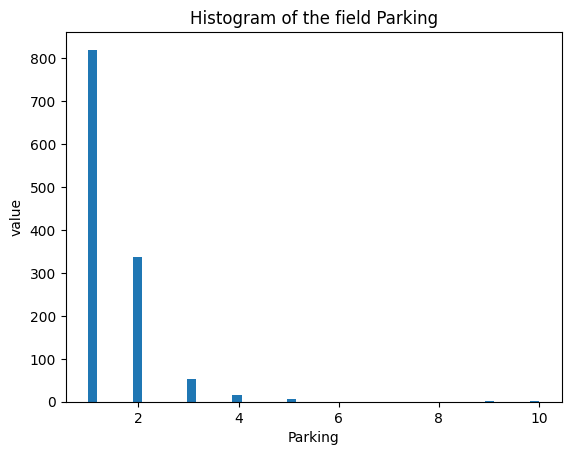

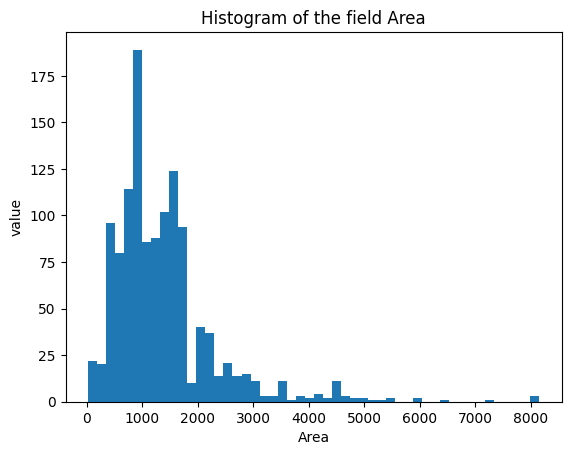

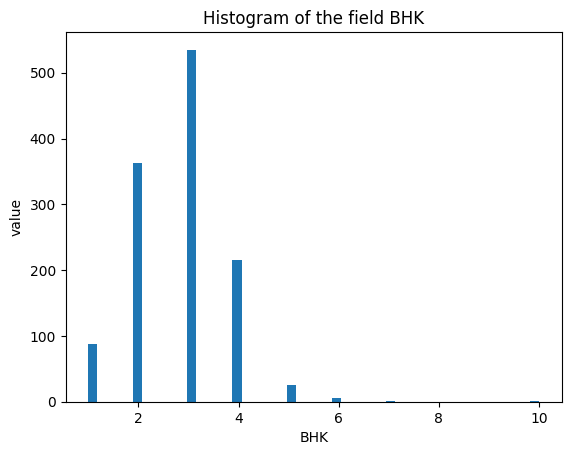

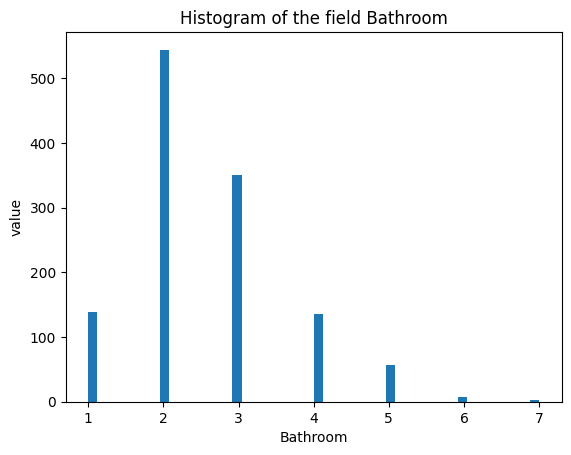

In [23]:
from pyspark.pandas import  DataFrame, set_option
import matplotlib.pyplot as plt
set_option('plotting.backend', 'matplotlib')
#For numeric values, we first have to plot the histogram to examime the distribution of these field
for field in ['Parking','Area','BHK','Bathroom']:
  ppdf = DataFrame(df)
  ax = ppdf[field].plot.hist(bins=50)
  ax.set_xlabel(field)
  ax.set_ylabel('value')
  ax.set_title(f'Histogram of the field {field}')
  plt.show()

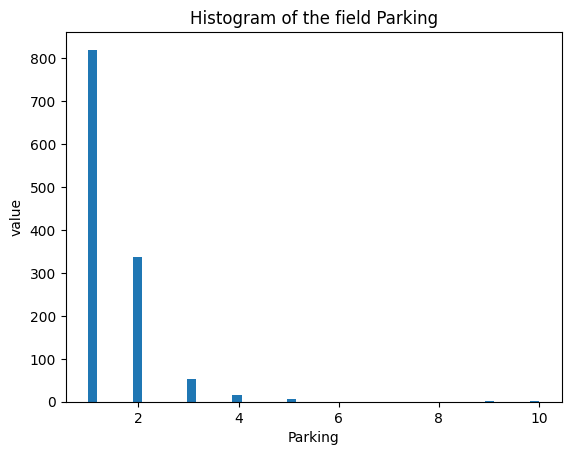

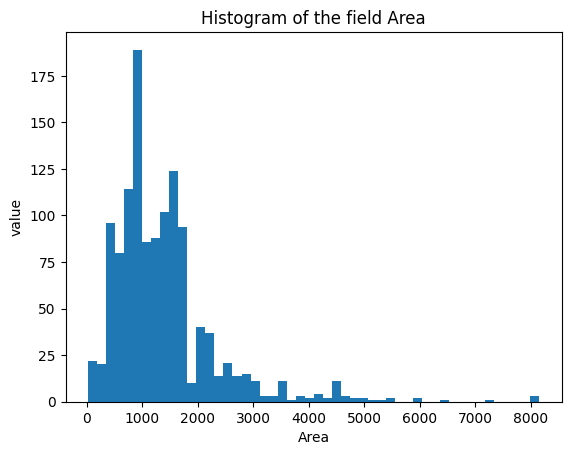

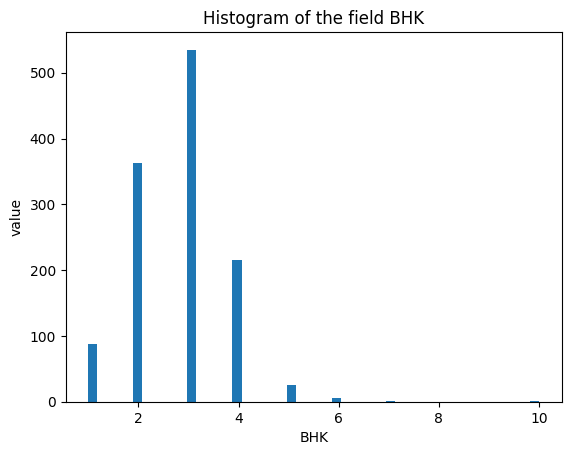

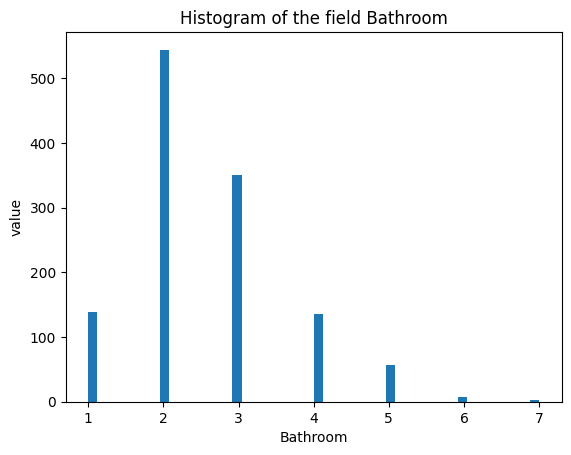

In [15]:
#after examining the distribution of the numerical value, we then cut off some of the outliners
df = df.filter((df['Parking']<=10) & (df['Area']<=10000))
for field in ['Parking','Area','BHK','Bathroom']:
  ppdf = DataFrame(df)
  ax = ppdf[field].plot.hist(bins=50)
  ax.set_xlabel(field)
  ax.set_ylabel('value')
  ax.set_title(f'Histogram of the field {field}')
  plt.show()

 ### 2.3. Process categorical data

The four categorical columns furnishing, status, transaction, type are quite clean and don't need further processing

In [25]:
df.groupby('Furnishing').count().show()
df.groupby('Status').count().show()
df.groupby('Transaction').count().show()
df.groupby('Type').count().show()

+--------------+-----+
|    Furnishing|count|
+--------------+-----+
|Semi-Furnished|  700|
|     Furnished|  183|
|   Unfurnished|  352|
+--------------+-----+

+-------------+-----+
|       Status|count|
+-------------+-----+
|Ready_to_move| 1162|
| Almost_ready|   73|
+-------------+-----+

+------------+-----+
| Transaction|count|
+------------+-----+
|      Resale|  764|
|New_Property|  471|
+------------+-----+

+-------------+-----+
|         Type|count|
+-------------+-----+
|    Apartment|  580|
|Builder_Floor|  655|
+-------------+-----+



However, the column Location has too many categories, some of them has only 1-2 samples in the whole dataset. This can can affect the analysis process as we move to the next stages.

In [26]:
grouped_locality = df.groupby('Locality').count().orderBy('Locality')
print('Number of categories: ', len(grouped_locality.collect()) )
grouped_locality.show(truncate=False)

Number of categories:  361
+----------------------------------------------------+-----+
|Locality                                            |count|
+----------------------------------------------------+-----+
|APL Builder Floor, Greater Kailash 1                |2    |
|Aashirwaad Chowk, Dwarka                            |6    |
|Abhimanyu Apartments, Vasundhara Enclave            |2    |
|Abul Fazal Enclave Part 1, Okhla                    |3    |
|Abul Fazal Enclave Part-II, Okhla                   |3    |
|Adarsh Homes, Dwarka Mor                            |3    |
|Ahinsha Vatika, Ram Nagar, Shahdara                 |1    |
|Alaknanda                                           |20   |
|Amar Colony, Lajpat Nagar                           |2    |
|Andheria Mor, Mehrauli                              |3    |
|Anekant Apartment, Vasundhara Enclave               |1    |
|Anupam Enclave, Saket                               |1    |
|Apna Apartments, Savitri Nagar Village, Sheikh Sarai|1   

As can be seen from the summary table above, some of the localities belong to the same larger district/area, we will group each group of similar localities to a larger category. Therefore we can have a smaller number of categories

In [27]:
def filterLocation(location):
    if len(location) > 100:
        return location
    
    filtered_area = location.rsplit(',',1)[-1].strip()
    
    # filter out unnecessary information for classifying location
    tokens = filtered_area.rsplit(' ', 1)
    if len(tokens) > 1 and tokens[-1].isdigit():
        filtered_area = tokens[0]
    
    pos = filtered_area.find('Sector')
    pos = filtered_area.find('Phase') if pos == -1 else pos
    pos = filtered_area.find('Block') if pos == -1 else pos
    pos = filtered_area.find('Pocket') if pos == -1 else pos
    
    if pos >= 0:
        filtered_area = filtered_area[:pos]
    
    return filtered_area.strip()

In [28]:
locality_convert = udf(filterLocation, StringType())
df = df.withColumn('filtered_locality', locality_convert(df.Locality))

In [29]:
filtered_locations = set()
for x in df.collect():
    if len(x['filtered_locality']) < 100:
        filtered_locations.add(x['filtered_locality'])

def filterLocation2(locations):
    def filterLongLocation(x):
        if len(x) < 100:
            return x
        for location in locations:
            if x.find(location) != -1:
                return location
        return x
    return udf(filterLongLocation)

In [30]:
df = df.withColumn('filtered_locality', filterLocation2(filtered_locations)('filtered_locality'))

In [31]:
minor_rows = df.groupby('filtered_locality').count().filter(col('count') < 5)
minor_categories = [row['filtered_locality'] for row in minor_rows.collect()]
df = df.withColumn('filtered_locality', udf(lambda x: 'others 'if x in minor_categories else x)('filtered_locality'))

In [32]:
df = df.drop('Locality')
df = df.withColumnRenamed('filtered_locality', 'Locality')

After the filtering process, the column Locality is left with 42 categories, a huge optimization. We also grouped all the low frequency categories to the same group, named "others"

In [33]:
grouped_locality = df.groupby('Locality').count().orderBy('Locality')
print('Number of categories: ', len(grouped_locality.collect()) )
grouped_locality.show()

Number of categories:  42
+--------------------+-----+
|            Locality|count|
+--------------------+-----+
|           Alaknanda|   56|
|          Budh Vihar|   18|
|         Chhattarpur|   22|
| Chhattarpur Enclave|    8|
|   Chittaranjan Park|   27|
|Commonwealth Game...|   28|
|      Dilshad Garden|   30|
|              Dwarka|   74|
|          Dwarka Mor|   13|
|        Geeta Colony|    5|
|     Greater Kailash|   40|
|           Hauz Khas|   30|
|             Kalkaji|   28|
|          Karol Bagh|   32|
|         Kirti Nagar|   28|
|        Lajpat Nagar|   88|
|         Laxmi Nagar|   34|
|     Mahavir Enclave|   13|
|Mahavir Enclave Part|   17|
|       Malviya Nagar|   30|
+--------------------+-----+
only showing top 20 rows



In [34]:
print('Number of columns after data cleaning: ', df.count())

Number of columns after data cleaning:  1235


## 3. Exploratory data analysis

In [35]:
import matplotlib.pyplot as plt

In [36]:
#For categorical data, first, we have to see number of distinct values in a specific field
for field in ['Furnishing', 'Status', 'Transaction', 'Type', 'Locality']:
  n = df.select(field).distinct().count()
  print(f'Field: {field} \nNumber of unique values: {n}\n\n')

Field: Furnishing 
Number of unique values: 3


Field: Status 
Number of unique values: 2


Field: Transaction 
Number of unique values: 2


Field: Type 
Number of unique values: 2


Field: Locality 
Number of unique values: 42




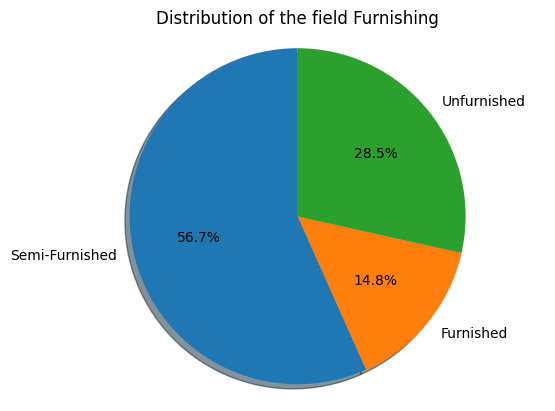

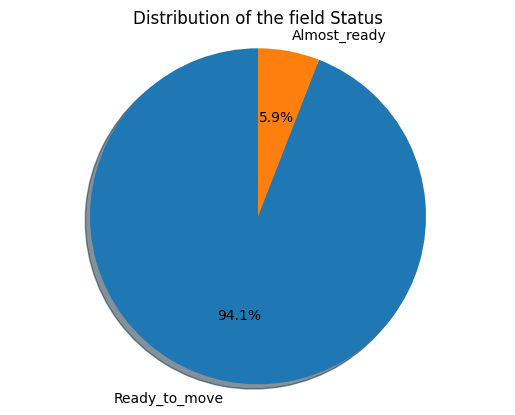

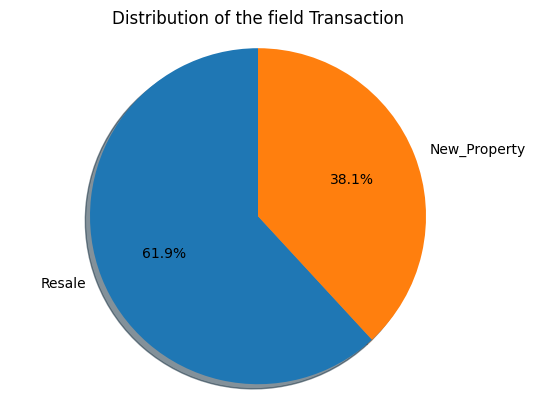

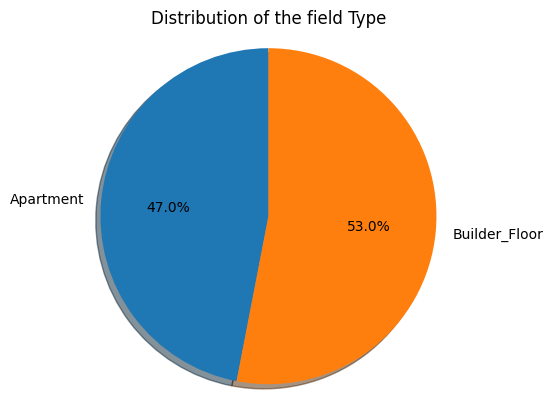

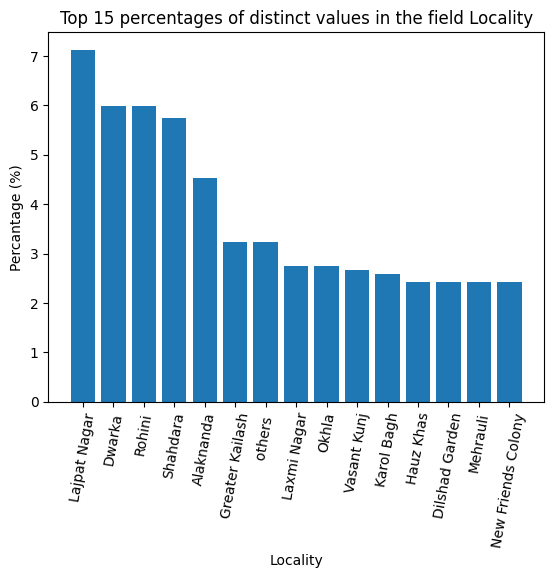

In [37]:
#plot distribution of categorical fields

import matplotlib.pyplot as plt
# first, we draw pie chart for the two field area_type, availability
for field in ['Furnishing', 'Status', 'Transaction', 'Type']:
  labels = df.groupBy(field).count().rdd.map(lambda x: x[0]).collect()
  sizes = df.groupBy(field).count().rdd.map(lambda x: x[1]).collect()

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  plt.title(f'Distribution of the field {field}')
  plt.show()

# as the field location has too many distinct value (>1200 distinct value), it is more appropriate to draw a barchar here:
labels = df.groupBy('Locality').count().sort(col('count').desc()).rdd.map(lambda x: x[0]).collect()
sizes = df.groupBy('Locality').count().sort(col('count').desc()).rdd.map(lambda x: x[1]).collect()
n_cols = df.count()
sizes = [ x/n_cols*100 for x in sizes]

plt.bar(labels[:15], sizes[:15])
plt.ylabel('Percantage (%)')
plt.xlabel('Locality')
plt.title('Top 15 percentages of distinct values in the field Locality')
plt.xticks(rotation=80)
plt.show()

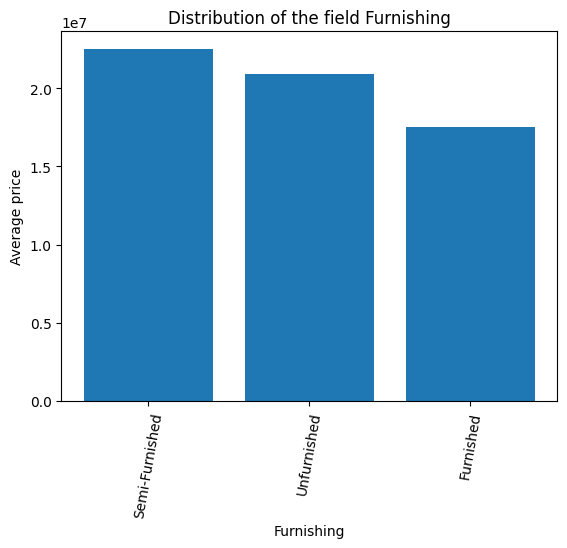

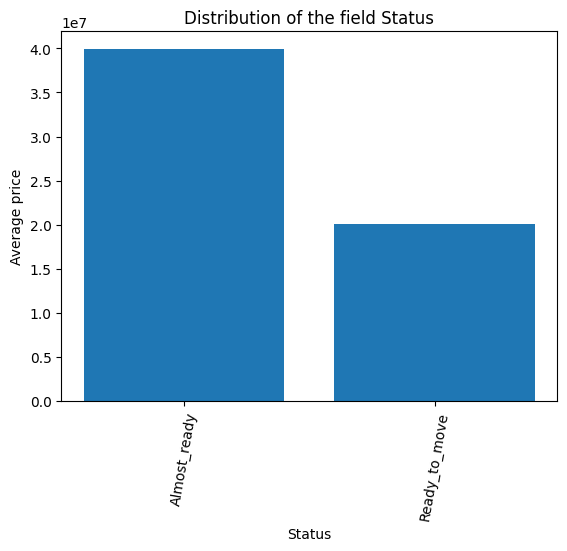

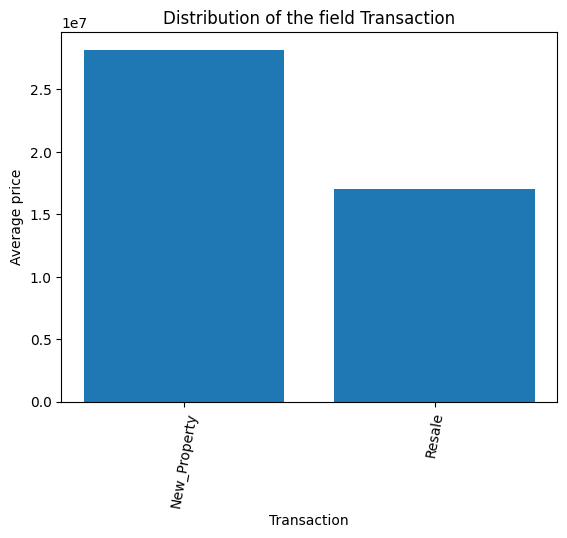

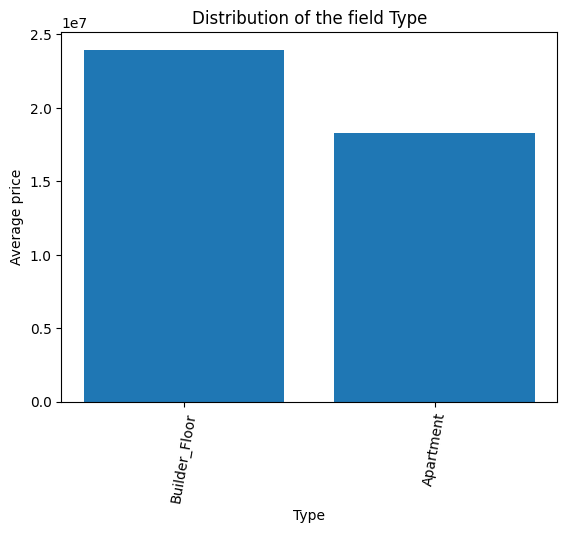

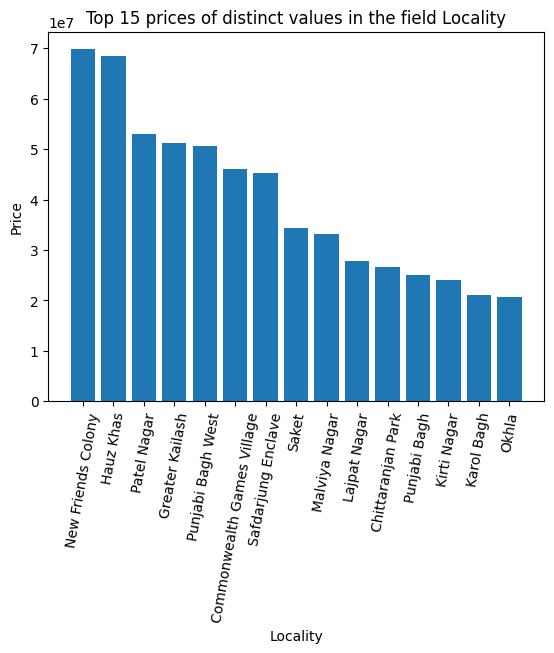

In [38]:
#Then, we compare the avarage house price between categories
import matplotlib.pyplot as plt
# first, we draw pie chart for the two field area_type, availability
for field in ['Furnishing', 'Status', 'Transaction', 'Type']:
  labels = df.groupBy(field).mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[0]).collect()
  sizes = df.groupBy(field).mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[5]).collect()

  plt.bar(labels, sizes)
  plt.ylabel('Average price')
  plt.xlabel(field)
  plt.title(f'Average prices between distinct values in the field {field}')
  plt.xticks(rotation=80)
  plt.title(f'Distribution of the field {field}')
  plt.show()

labels = df.groupBy('Locality').mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[0]).collect()
sizes = df.groupBy('Locality').mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[5]).collect()

plt.bar(labels[:15], sizes[:15])
plt.ylabel('Price')
plt.xlabel('Locality')
plt.title('Top 15 prices of distinct values in the field Locality')
plt.xticks(rotation=80)
plt.show()

In [39]:
df.show(2)

+-----+---+--------+--------------+-------+-------+-------------+------------+-------------+--------+
| Area|BHK|Bathroom|    Furnishing|Parking|  Price|       Status| Transaction|         Type|Locality|
+-----+---+--------+--------------+-------+-------+-------------+------------+-------------+--------+
|800.0|  3|       2|Semi-Furnished|      1|6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|750.0|  2|       2|Semi-Furnished|      1|5000000|Ready_to_move|New_Property|    Apartment|  Rohini|
+-----+---+--------+--------------+-------+-------+-------------+------------+-------------+--------+
only showing top 2 rows



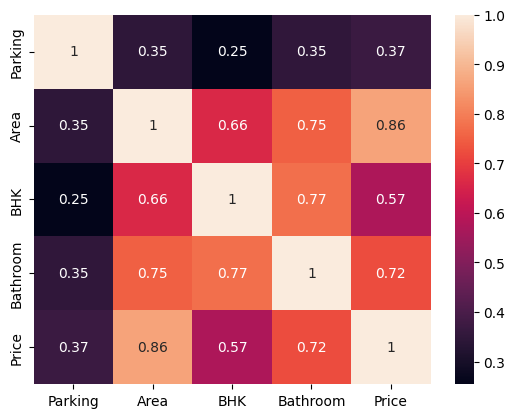

In [42]:
# As we have seen the distribution of each numeric column in the previous section, we now will examine the corollation between numeric field to each other
import seaborn as sns
import numpy as np
confusion_matrix = []
for field1 in ['Parking','Area','BHK','Bathroom', 'Price']:
  confusion_matrix_row = []
  for field2 in ['Parking','Area','BHK','Bathroom', 'Price']:
    x = df.select(field2).rdd.flatMap(lambda x: x).collect()
    y = df.select(field1).rdd.flatMap(lambda x: x).collect()
    confusion_matrix_row.append(np.corrcoef(x, y)[0][1])
  confusion_matrix.append(confusion_matrix_row)
confusion_matrix = np.array(confusion_matrix)
ax = sns.heatmap(confusion_matrix, annot=True, xticklabels = ['Parking','Area','BHK','Bathroom', 'Price'], yticklabels = ['Parking','Area','BHK','Bathroom', 'Price'])  

## 4. Pyspark ML Lib

In this part, we will build some models to predict house price from other information. The first step is to extract features that can be 
used to fit the prediction models, from the columns

### 4.1. Feature extraction

In [43]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, MinMaxScaler, VectorAssembler

In [44]:
df.show(20)

+--------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
|    Area|BHK|Bathroom|    Furnishing|Parking|   Price|       Status| Transaction|         Type|Locality|
+--------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
|   800.0|  3|       2|Semi-Furnished|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|   750.0|  2|       2|Semi-Furnished|      1| 5000000|Ready_to_move|New_Property|    Apartment|  Rohini|
|   950.0|  2|       2|     Furnished|      1|15500000|Ready_to_move|      Resale|    Apartment|  Rohini|
|   600.0|  2|       2|Semi-Furnished|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|  Rohini|
|   650.0|  2|       2|Semi-Furnished|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|  1300.0|  4|       3|Semi-Furnished|      1|15500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|  1350.0|  4|       3|Semi-Furnished|      1|

There are 2 steps to process categorical data.
1. Transform strings to indexes.
2. One hot encode the indexed values. The result is a list of one-hot-encoded vectors

We will use the two Pyspark classes, **StringIndexer** and **OneHotEncoder** for this two steps

In [45]:
string_indexer = StringIndexer(
    inputCols=['Furnishing', 'Status', 'Transaction', 'Type', 'Locality'],
    outputCols=['indexed_furnishing', 'indexed_status', 'indexed_transaction', 'indexed_type', 'indexed_locality']
)
    
# demonstrate the output of StringIndexer
show_df = string_indexer.fit(df).transform(df)
show_df.select(['indexed_furnishing', 'indexed_status', 'indexed_transaction', 'indexed_type', 'indexed_locality']).show(5)

+------------------+--------------+-------------------+------------+----------------+
|indexed_furnishing|indexed_status|indexed_transaction|indexed_type|indexed_locality|
+------------------+--------------+-------------------+------------+----------------+
|               0.0|           0.0|                1.0|         0.0|             2.0|
|               0.0|           0.0|                1.0|         1.0|             2.0|
|               2.0|           0.0|                0.0|         1.0|             2.0|
|               0.0|           0.0|                0.0|         0.0|             2.0|
|               0.0|           0.0|                1.0|         0.0|             2.0|
+------------------+--------------+-------------------+------------+----------------+
only showing top 5 rows



In [46]:
one_hot_encoder = OneHotEncoder(
    inputCols=['indexed_furnishing', 'indexed_status', 'indexed_transaction', 'indexed_type', 'indexed_locality'],
    outputCols=['encoded_furnishing', 'encoded_status', 'encoded_transaction', 'encoded_type', 'encoded_locality'],
    dropLast=False
)
# demonstrate the output of OneHotEncoder
show_df = one_hot_encoder.fit(show_df).transform(show_df)
show_df.select(['encoded_furnishing', 'encoded_status', 'encoded_transaction', 'encoded_type', 'encoded_locality']).show(5)

+------------------+--------------+-------------------+-------------+----------------+
|encoded_furnishing|encoded_status|encoded_transaction| encoded_type|encoded_locality|
+------------------+--------------+-------------------+-------------+----------------+
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[1],[1.0])|(2,[0],[1.0])|  (42,[2],[1.0])|
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[1],[1.0])|(2,[1],[1.0])|  (42,[2],[1.0])|
|     (3,[2],[1.0])| (2,[0],[1.0])|      (2,[0],[1.0])|(2,[1],[1.0])|  (42,[2],[1.0])|
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[0],[1.0])|(2,[0],[1.0])|  (42,[2],[1.0])|
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[1],[1.0])|(2,[0],[1.0])|  (42,[2],[1.0])|
+------------------+--------------+-------------------+-------------+----------------+
only showing top 5 rows



Numeric variables will be normalized for the ease of calculation. We use **VectorAssembler** to assemble all numeric values to
a single vector, then **MinMaxScaler** is used to standardized that vector.

In [47]:
numeric_assembler = VectorAssembler(inputCols=['Area','BHK','Bathroom','Parking'], outputCol=f'numeric_vec')
# scaler = StandardScaler(inputCol='numeric_vec', outputCol='scaled_numeric')
scaler = MinMaxScaler(inputCol='numeric_vec', outputCol='scaled_numeric')
show_df = numeric_assembler.transform(show_df)
show_df = scaler.fit(show_df).transform(show_df)

In [48]:
show_df.select(['scaled_numeric']).show(5, truncate=False)

+----------------------------------------------------------------+
|scaled_numeric                                                  |
+----------------------------------------------------------------+
|[0.09505048017729624,0.2222222222222222,0.16666666666666666,0.0]|
|[0.08889436099482886,0.1111111111111111,0.16666666666666666,0.0]|
|[0.11351883772469835,0.1111111111111111,0.16666666666666666,0.0]|
|[0.07042600344742675,0.1111111111111111,0.16666666666666666,0.0]|
|[0.07658212262989411,0.1111111111111111,0.16666666666666666,0.0]|
+----------------------------------------------------------------+
only showing top 5 rows



Next we concatenate all the features, including categorical and numeric features into one final vector feature.

In [49]:
assembler = VectorAssembler(inputCols=['encoded_furnishing', 'encoded_status', 'encoded_transaction', 
                                       'encoded_type', 'encoded_locality','scaled_numeric'], outputCol='features')
show_df = assembler.transform(show_df)
show_df.select('features').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|features                                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|(55,[0,3,6,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.09505048017729624,0.2222222222222222,0.16666666666666666])|
|(55,[0,3,6,8,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.08889436099482886,0.1111111111111111,0.16666666666666666])|
|(55,[2,3,5,8,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.11351883772469835,0.1111111111111111,0.16666666666666666])|
|(55,[0,3,5,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.07042600344742675,0.1111111111111111,0.16666666666666666])|
|(55,[0,3,6,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.07658212262989411,0.1111111111111111,0.16666666666666666])|
+-----------------------------------------------------------------------------------------------------------+
only showi

We will create a **Pipeline** object that wraps all the feature extraction modules so that we can run the whole process end-to-end.

In [50]:
from pyspark.ml import Pipeline
features_pipeline = Pipeline(stages=[string_indexer, one_hot_encoder, numeric_assembler, scaler, assembler])
features_extractor = features_pipeline.fit(df)

In [51]:
features_extractor.transform(df).select('features').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|features                                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|(55,[0,3,6,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.09505048017729624,0.2222222222222222,0.16666666666666666])|
|(55,[0,3,6,8,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.08889436099482886,0.1111111111111111,0.16666666666666666])|
|(55,[2,3,5,8,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.11351883772469835,0.1111111111111111,0.16666666666666666])|
|(55,[0,3,5,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.07042600344742675,0.1111111111111111,0.16666666666666666])|
|(55,[0,3,6,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.07658212262989411,0.1111111111111111,0.16666666666666666])|
+-----------------------------------------------------------------------------------------------------------+
only showi

### 4.1. Regression model

First we create a Linear Regression object. We need to specify the input column and output column, leave other arguments with default values 
Also set standardization to False because we have already normalized the data at feature engineering process.

In [52]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='Price', predictionCol='prediction', standardization=False)

Split the data into train and test sets

In [53]:
train_df,test_df = df.randomSplit([0.8,0.2], seed=1234)

Now train the mode with train_df

In [54]:
lr_model = lr.fit(features_extractor.transform(train_df))

22/11/23 06:37:29 WARN Instrumentation: [8d94d4af] regParam is zero, which might cause numerical instability and overfitting.
22/11/23 06:37:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/23 06:37:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/11/23 06:37:29 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/11/23 06:37:29 WARN Instrumentation: [8d94d4af] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Make predictions on test set

In [55]:
lr_predictions = lr_model.transform(features_extractor.transform(test_df))

In [56]:
lr_predictions.select([col('Price').alias('Label'), 'prediction']).tail(10)

[Row(Label=65000000, prediction=70148124.20462835),
 Row(Label=75000000, prediction=66375174.65870559),
 Row(Label=60000000, prediction=66927229.7504769),
 Row(Label=70000000, prediction=71767909.78308812),
 Row(Label=22500000, prediction=70931740.57720773),
 Row(Label=58000000, prediction=79664587.48868911),
 Row(Label=79000000, prediction=86105578.48860386),
 Row(Label=115000000, prediction=84958451.57479277),
 Row(Label=135000000, prediction=103715003.43602295),
 Row(Label=170000000, prediction=164680586.87171438)]

Evaluate the predictions with ground truth labels. We will calculate the r2 score of the model on test set

In [57]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Price', metricName='r2')
evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

0.8418146787455809

In [58]:
# define the model
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='Price', predictionCol='prediction')

# train the model on train set
rf_model = rf.fit(features_extractor.transform(train_df))

# make predictions on test set
rf_predictions = rf_model.transform(features_extractor.transform(test_df))

# Evaluate
rf_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Price', metricName='r2')
rf_evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

0.8468271102807039

### 4.2 Classification models

To setup our experiment for classification models, we split house prices into three categories: **Low**, **Medium** and **High** based on Q1 and Q3 values

In [59]:
from pyspark.sql.functions import mean
# mean_price = df.select(mean(df['Price'])).collect()[0][0]
q1, q3 = df.approxQuantile("Price", [0.25, 0.75], 0)
print("Q1 value: ", q1)
print("Q3 value: ", q3)

Q1 value:  5800000.0
Q3 value:  25900000.0


From the calculated quantiles, Low price is from 0 to 5.800.000, medium price is from 5.800.000 to 25.900.000, high price is above 25.900.000

In [60]:
def price_segmentation(x):
#     Low
    if x < 5800000:
        return 0.0
#     Medium
    elif 5800000 <= x <= 25900000:
        return 1.0
#     High
    else:
        return 2.0
df = df.withColumn('price_category', udf(price_segmentation, FloatType())(df['Price']))

In [61]:
df.groupby("price_category").count().show()

+--------------+-----+
|price_category|count|
+--------------+-----+
|           2.0|  308|
|           1.0|  619|
|           0.0|  308|
+--------------+-----+



In [62]:
features_extractor = features_pipeline.fit(df)

In [63]:
train_df,test_df = df.randomSplit([0.8,0.2], seed=1234)

Logistic regression

In [64]:
# Define the model
from pyspark.ml.classification import LogisticRegression
log_r = LogisticRegression(featuresCol='features', labelCol='price_category', predictionCol='prediction')

# fit the model with train set
log_r_model = log_r.fit(features_extractor.transform(train_df))

# make predictions on test set
log_r_predictions = log_r_model.transform(features_extractor.transform(test_df))
log_r_predictions.select(col('price_category').alias('label'), 'prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [65]:
preds = [x[0] for x in log_r_predictions.select('prediction').collect()]
gts = [x[0] for x in log_r_predictions.select('price_category').collect()]
# Calculate accuracy
correct = 0
for pred, gt in zip(preds, gts):
    if pred == gt:
        correct += 1
print(correct / len(preds))

0.8489795918367347


In [66]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
log_r_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='price_category')
log_r_evaluator.evaluate(log_r_predictions)

0.8965960179833012

Multilayer perceptron

In [67]:
# from pyspark.ml.classification import MultilayerPerceptronClassifier
# mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='price_category', predictionCol='prediction', 
#                                      blockSize=64, layers=[55, 1024, 3], solver='gd', stepSize=0.01, maxIter=10000)

In [68]:
# mlp_model = mlp.fit(features_extractor.transform(train_df))

In [69]:
# import matplotlib.pyplot as plt
# plt.plot(mlp_model.summary().objectiveHistory)

In [70]:
# mlp_predictions = mlp_model.transform(features_extractor.transform(train_df))
# mlp_predictions.show(10, False)

In [71]:
# mlp_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='price_category')
# mlp_evaluator.evaluate(mlp_predictions)

### 4.3 K-means clustering

K-means clustering to classify houses to different clusters

In [72]:
# Group numeric values in a row into a numeric vector
numeric_assembler = VectorAssembler(inputCols=['Area','BHK','Bathroom','Parking','Price'], outputCol=f'numeric_vec')
assembled = numeric_assembler.transform(df)

# Scale and standardize data by using StandardScalerModel
scaler = StandardScaler(inputCol='numeric_vec', outputCol='features')
data = scaler.fit(assembled).transform(assembled)
data.select(['features']).show(5, truncate=False)

+-------------------------------------------------------------------------------------------------+
|features                                                                                         |
+-------------------------------------------------------------------------------------------------+
|[0.8364949736732389,3.172635307548206,1.9377970190850902,1.3115518730635414,0.25545190924496297] |
|[0.7842140378186614,2.1150902050321374,1.9377970190850902,1.3115518730635414,0.1965014686499715] |
|[0.9933377812369711,2.1150902050321374,1.9377970190850902,1.3115518730635414,0.6091545528149117] |
|[0.6273712302549291,2.1150902050321374,1.9377970190850902,1.3115518730635414,0.16506123366597605]|
|[0.6796521661095066,2.1150902050321374,1.9377970190850902,1.3115518730635414,0.24366182112596466]|
+-------------------------------------------------------------------------------------------------+
only showing top 5 rows



Evaluate the clustering costs from k=1 to k=10

In [73]:
from pyspark.ml.clustering import KMeans

no_cluster = 10;
cost = [0] * (no_cluster + 1)
for k in range(2, no_cluster + 1):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(data)
    cost[k] = model.summary.trainingCost
    print('Cost k={}:'.format(k), cost[k])

Cost k=2: 3615.398839547335
Cost k=3: 2739.4321740042615
Cost k=4: 2354.9072178305487
Cost k=5: 1944.586573608512
Cost k=6: 1787.273487911017
Cost k=7: 1691.150433884
Cost k=8: 1493.0380225139263
Cost k=9: 1361.165413357026
Cost k=10: 1347.7228750929855


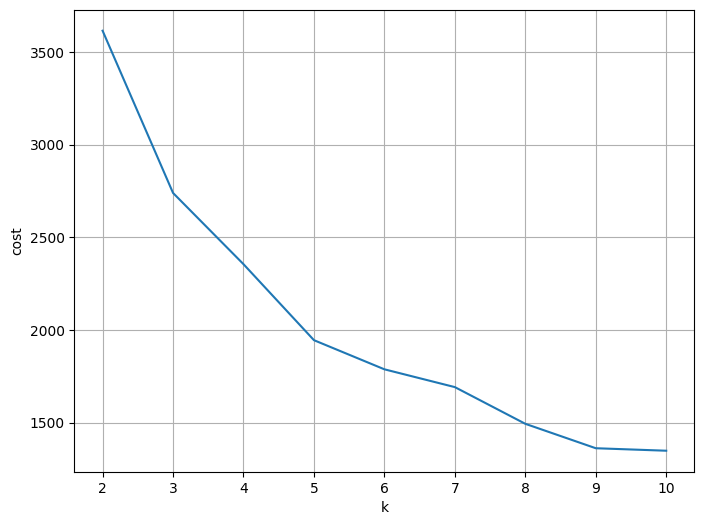

In [74]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2, no_cluster + 1), cost[2:no_cluster + 1])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()

In [81]:
import time
import numpy as np
from pyspark.ml.evaluation import ClusteringEvaluator

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    start = time.time()
    silh_lst = []
    k_lst = range(k_min, k_max + 1)

    for k in k_lst:
        silh_val = []
        for run in range(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setFeaturesCol(index_col)\
                    .setSeed(123)
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        # Take average
        silh_array=np.asanyarray(silh_val)
        print("Score k={}:".format(k), silh_array.mean())
        silh_lst.append(float(silh_array.mean()))

    elapsed =  time.time() - start

    silhouette = spark.createDataFrame(list(zip(k_lst, silh_lst))).toDF('k', 'silhouette')

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')

    return silhouette


In [82]:
# Getting the optimal number of clusters by finding silhouette coefficients
# Input: dataset, indexed feature column name, min k, max k, number of runs
# Output: a list of silhouette scores from k = 2 to k = 10 by running each k value 5 time.

silh_lst = optimal_k(data, 'features', 2, 10, 5)

Score k=2: 0.7185841189832898
Score k=3: 0.4771533626937746
Score k=4: 0.45568933596496
Score k=5: 0.4661745636762832
Score k=6: 0.4786596410947837
Score k=7: 0.4260958911337515
Score k=8: 0.44324351309237287
Score k=9: 0.43589965375885587
Score k=10: 0.46832343647036445
+------------------------------------------------------------+
|         The finding optimal k phase took       32 s.       |
+------------------------------------------------------------+


In [83]:
silh_lst.show()

+---+-------------------+
|  k|         silhouette|
+---+-------------------+
|  2| 0.7185841189832898|
|  3| 0.4771533626937746|
|  4|   0.45568933596496|
|  5| 0.4661745636762832|
|  6| 0.4786596410947837|
|  7| 0.4260958911337515|
|  8|0.44324351309237287|
|  9|0.43589965375885587|
| 10|0.46832343647036445|
+---+-------------------+



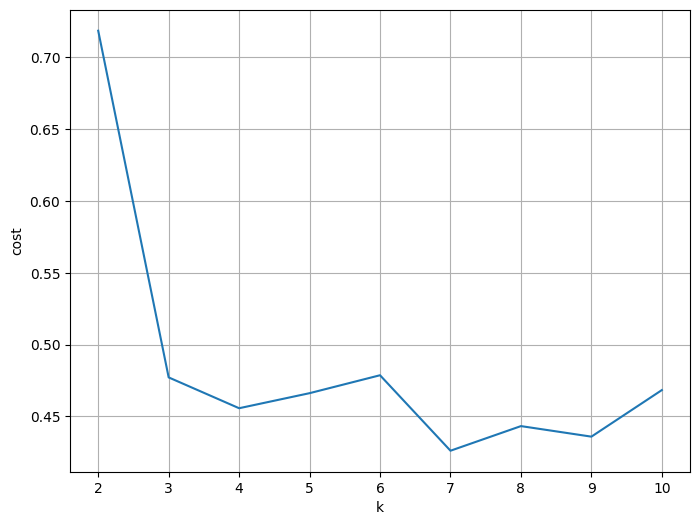

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2, no_cluster + 1), [x['silhouette'] for x in silh_lst.collect()])

ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()

In [85]:
kmeans = KMeans() \
          .setK(6) \
          .setFeaturesCol("features")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
# Get stage from transformer and K-Means
pipeline = Pipeline(stages=[numeric_assembler , kmeans])
pre_clustered_data = data.drop('numeric_vec')
model = pipeline.fit(pre_clustered_data)
clustered_data = model.transform(pre_clustered_data)

Base on the figure above, choose k=6 because there is significant increase in among 4-8.

In [87]:
clustered_data.show(20)

+--------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+--------------+--------------------+--------------------+-------+
|    Area|BHK|Bathroom|    Furnishing|Parking|   Price|       Status| Transaction|         Type|Locality|price_category|            features|         numeric_vec|cluster|
+--------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+--------------+--------------------+--------------------+-------+
|   800.0|  3|       2|Semi-Furnished|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|           1.0|[0.83649497367323...|[800.0,3.0,2.0,1....|      3|
|   750.0|  2|       2|Semi-Furnished|      1| 5000000|Ready_to_move|New_Property|    Apartment|  Rohini|           0.0|[0.78421403781866...|[750.0,2.0,2.0,1....|      3|
|   950.0|  2|       2|     Furnished|      1|15500000|Ready_to_move|      Resale|    Apartment|  Rohini|           1.0|[0.99333778123697...|[950